In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [0]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def resize_image(path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(path, format="JPEG", quality=90)
    print("Image downloaded to %s." % path)
    if display:
        display_image(pil_image)
    return path


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=20, min_score=0.5):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [3]:
image_url = "https://farm1.staticflickr.com/4032/4653948754_c0d768086b_o.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Found 100 objects.


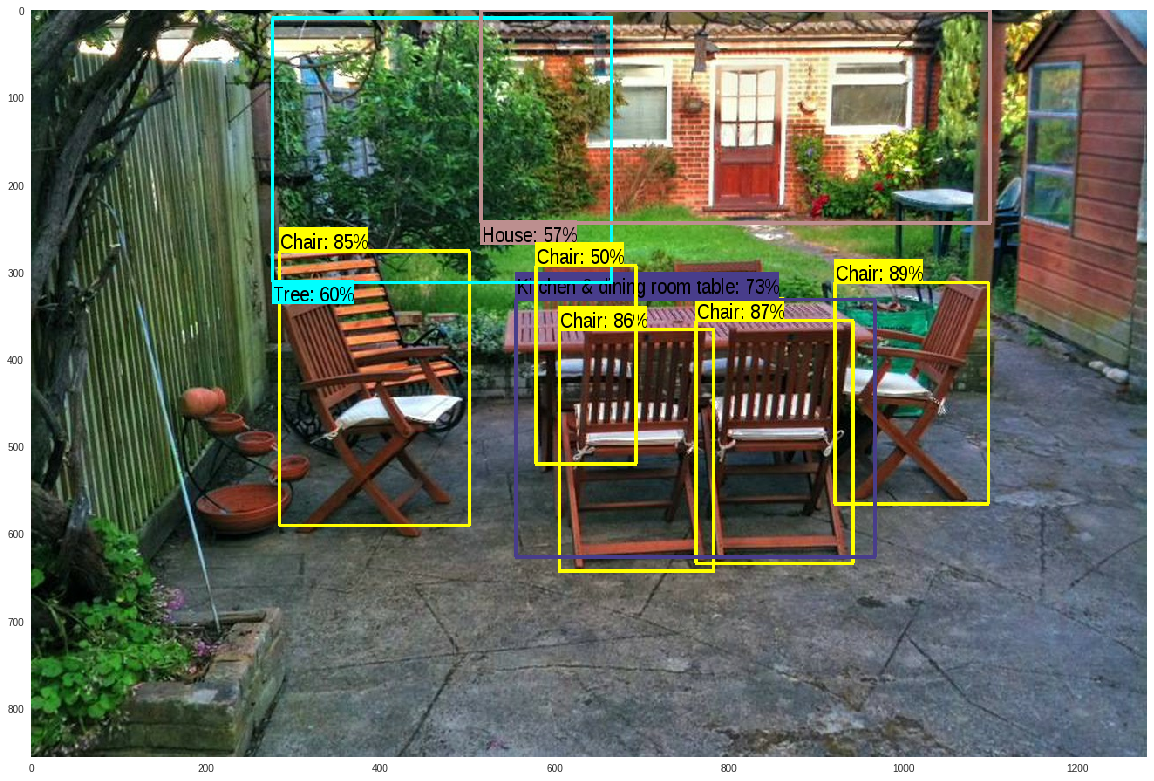

In [4]:
with tf.Graph().as_default():
    detector = hub.Module("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")
    image_string_placeholder = tf.placeholder(tf.string)
    decoded_image = tf.image.decode_jpeg(image_string_placeholder)
    # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
    # of size 1 and type tf.float32.
    decoded_image_float = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    module_input = tf.expand_dims(decoded_image_float, 0)
    result = detector(module_input, as_dict=True)
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

    session = tf.Session()
    session.run(init_ops)

    # URL을 통해 이미지 다운 받고 불러오기 
    with tf.gfile.Open(downloaded_image_path, "rb") as binfile:
        image_string = binfile.read()

    result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
    print("Found %d objects." % len(result_out["detection_scores"]))

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

display_image(image_with_boxes)

In [9]:
from google.colab import files
uploaded = files.upload()
image_files = uploaded.keys()

Saving 61LpDnx9c-L._SL500_AC_SS350_.jpg to 61LpDnx9c-L._SL500_AC_SS350_.jpg


Image downloaded to 61LpDnx9c-L._SL500_AC_SS350_.jpg.


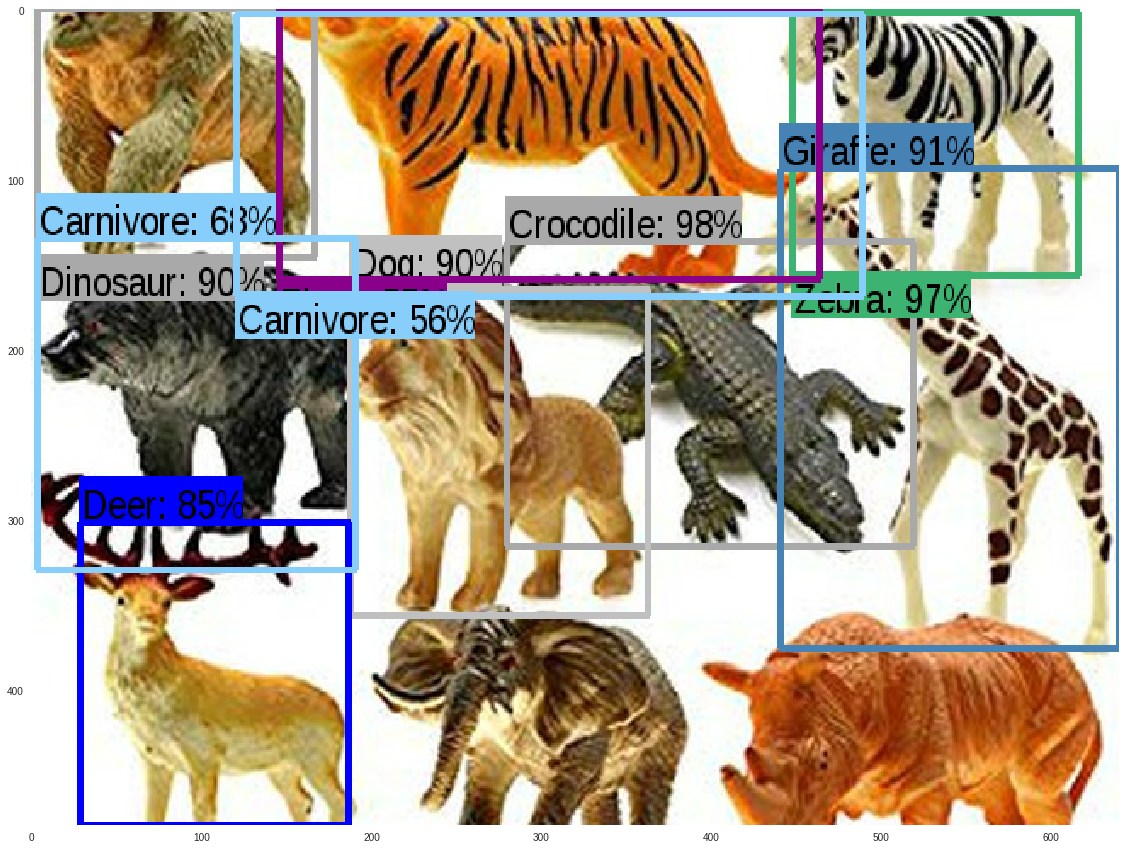

In [10]:
for image_url in image_files:
    image_path = resize_image(image_url, 640, 480)
    with tf.gfile.Open(image_path, "rb") as binfile:
        image_string = binfile.read()

    result_out, image_out = session.run(
        [result, decoded_image], 
        feed_dict={image_string_placeholder: image_string})

    image_with_boxes = draw_boxes(np.array(image_out), 
                                  result_out["detection_boxes"], 
                                  result_out["detection_class_entities"], 
                                  result_out["detection_scores"])

    display_image(image_with_boxes)
    

In [11]:
image_urls = ["https://farm7.staticflickr.com/8092/8592917784_4759d3088b_o.jpg",
              "https://farm6.staticflickr.com/2598/4138342721_06f6e177f3_o.jpg",
              "https://c4.staticflickr.com/9/8322/8053836633_6dc507f090_o.jpg"]

for image_url in image_urls:
    image_path = download_and_resize_image(image_url, 640, 480)
    with tf.gfile.Open(image_path, "rb") as binfile:
        image_string = binfile.read()

    result_out, image_out = session.run(
        [result, decoded_image], 
        feed_dict={image_string_placeholder: image_string})

    image_with_boxes = draw_boxes(np.array(image_out), 
                                  result_out["detection_boxes"], 
                                  result_out["detection_class_entities"], 
                                  result_out["detection_scores"])

    display_image(image_with_boxes)
    